In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.utils import get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler

import sys
sys.path.append('selex_dca')
from selex_dca import *

/Users/scrotti/adabmDCApy/experiments/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# import importlib
# import selex_dca
# importlib.reload(selex_dca)

File names for data

In [3]:
experiment_id = "Dop8V930"
round_ids = ["ARN", "R01", "R02N"]

In [4]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


Extract sequences and compute 1st and 2nd moment statistics

In [5]:
sequences = [sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [6]:
pseudo_count = 0.001

In [7]:
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[frequences_from_sequences(seq, pseudo_count=pseudo_count, dtype=dtype) for seq in sequences])

In [8]:
fi = torch.stack(freq_single_tuple)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple)      # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple, dtype=dtype)

n_rounds, L, q = fi.size()

Pick a sampling strategy for MCMC

In [9]:
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg))

In [14]:
nchains = 10000

params = init_parameters(fi=fi) # initialize with frequences at last round
chains = init_chains(num_rounds=n_rounds, num_chains=nchains, L=L, q=q, device=device, fi=fi)

mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
# Mask for saving only the upper diagnal part of the weight_matrix
mask_save = get_mask_save(L=L, q=q, device=device)
history = init_history()
log_weights = torch.zeros(n_rounds, nchains, device=device, dtype=dtype)

Train

In [41]:
nsweeps = 10
lr = 0.01

ch, par, history = train(
    sampler=sampler,
    chains=chains,
    fi=fi,
    fij=fij,
    total_reads=total_reads,
    params=params,
    mask=mask,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=2000,
    target_pearson=0.98,
    history=history,
    log_weights=log_weights,
    progress_bar=True
    )

 0.00%[                                                  ] Epoch: 0/2000 [00:00]

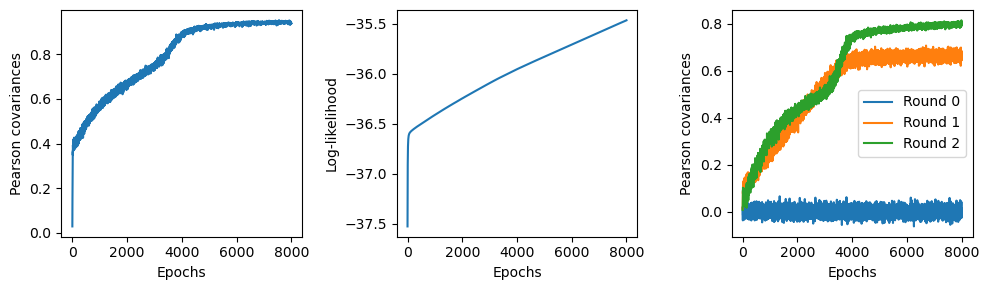

In [42]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot(history["pearson"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Pearson covariances")
ax2.plot(history["log-likelihood"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Log-likelihood")
ax3.plot(history["pearson_rounds"], label=[f"Round {r}" for r in range(len(round_ids))])
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Pearson covariances")
ax3.legend()
f.tight_layout()

### Compare with empirical abundances

In [43]:
ts = range(len(round_ids))

sequences_unique, inverse_indices, counts = zip(*[
    torch.unique(sequences[t], dim=0, return_inverse=True, return_counts=True)
    for t in ts])
sequences_unique_oh = [one_hot(s) for s in sequences_unique]

In [44]:
num_seq = [len(sequences[t]) for t in ts]
num_seq

[10870425, 3650179, 3771797]

In [45]:
params_t = [get_params_at_round(params, t) for t in ts]
logselect_t = [-adabmDCA.statmech.compute_energy(sequences_unique_oh[t], params_t[t])
               for t in ts]

In [50]:
# C = 20
logNst_thresh = -25

# def vectors_for_scatterplot(counts, inverse_indices, C, logselect_t):
#     counts_all = counts[inverse_indices]
#     idx_unique_over_thresh = counts_all >= C
#     x = logselect_t[inverse_indices][idx_unique_over_thresh]
#     y = torch.log(counts_all[idx_unique_over_thresh])
#     return x, y

def vectors_for_scatterplot(counts, inverse_indices, logNst_thresh, logselect_t):
    counts_all = counts[inverse_indices]
    idx_unique_over_thresh = logselect_t[inverse_indices] >= logNst_thresh
    x = logselect_t[inverse_indices][idx_unique_over_thresh]
    y = torch.log(counts_all[idx_unique_over_thresh])
    return x, y

X, Y = zip(*[vectors_for_scatterplot(counts[t], inverse_indices[t], logNst_thresh, logselect_t[t]) for t in ts]) 

pearson = [torch.corrcoef(torch.stack((x, y)))[0,1] for (x,y) in zip(X,Y)]

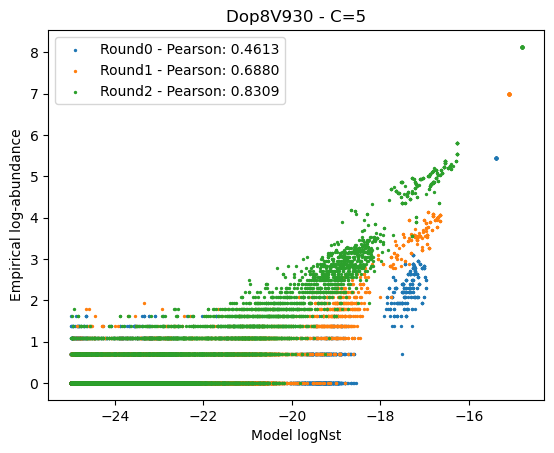

In [51]:
import random
N = 10**4

fig, ax = plt.subplots()

for t in ts:
    x = X[t]; y = Y[t]
    idx = random.sample(range(len(x)),min(N, len(x)))
    ax.scatter(x[idx], y[idx], label=f"Round{t} - Pearson: {pearson[t]:.{4}f}", s=2)
    ax.set_xlabel("Model logNst")
    ax.set_ylabel("Empirical log-abundance")
    ax.set_title(f"{experiment_id} - C={C}")
ax.legend()

In [48]:
import pickle

filename = experiment_id + ".pkl"
filepath = "saved/" + filename

# data = {"experiment_id": experiment_id, 
#         "round_ids": round_ids, 
#         "params": params, 
#         "params_t": params_t,
#         "logselect_t": logselect_t,
#         "counts": counts,
#         "inverse_indices": inverse_indices
#        }
data = [experiment_id, round_ids, params, params_t, logselect_t,
        counts, inverse_indices, num_seq]

with open(filepath, 'wb') as f:
    pickle.dump(data, f)